In [91]:
import h5py
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
import os

def datx2py(file_name):
    """Loads a .datx into Python, credit goes to gkaplan.
    https://gist.github.com/g-s-k/ccffb1e84df065a690e554f4b40cfd3a"""
    def _group2dict(obj):
        return {k: _decode_h5(v) for k, v in zip(obj.keys(), obj.values())}
    def _struct2dict(obj):
        names = obj.dtype.names
        return [dict(zip(names, _decode_h5(record))) for record in obj]
    def _decode_h5(obj):
        if isinstance(obj, h5py.Group):
            d = _group2dict(obj)
            if len(obj.attrs):
                d['attrs'] = _decode_h5(obj.attrs)
            return d
        elif isinstance(obj, h5py.AttributeManager):
            return _group2dict(obj)
        elif isinstance(obj, h5py.Dataset):
            d = {'attrs': _decode_h5(obj.attrs)}
            try:
                d['vals'] = obj[()]
            except (OSError, TypeError):
                pass
            return d
        elif isinstance(obj, np.ndarray):
            if np.issubdtype(obj.dtype, np.number) and obj.shape == (1,):
                return obj[0]
            elif obj.dtype == 'object':
                return _decode_h5([_decode_h5(o) for o in obj])
            elif np.issubdtype(obj.dtype, np.void):
                return _decode_h5(_struct2dict(obj))
            else:
                return obj
        elif isinstance(obj, np.void):
            return _decode_h5([_decode_h5(o) for o in obj])
        elif isinstance(obj, bytes):
            return obj.decode()
        elif isinstance(obj, list) or isinstance(obj, tuple):
            if len(obj) == 1:
                return obj[0]
            else:
                return obj
        else:
            return obj
    with h5py.File(file_name, 'r') as f:
        h5data = _decode_h5(f)
    return h5data

def get_data(datx_file):
    """Returns the Surface and Intensity data from a single .datx file"""
    myh5 = datx2py(datx_file)                      # File is the string with the location of the file
    zsurf = myh5['Data']['Surface']           # Get the surfaces
    zdata = list(zsurf.values())[0]           # Good for fixing stuff later  
    zsurf = zdata['vals']                     # Get the data from the surface group
    zsurf[zsurf == zdata['attrs']['No Data']] = np.nan  # Write no data as NaNs for compatibility
    zint = myh5['Data']['Intensity']          # Get the intensity group
    zint = list(zint.values())[0]['vals'].astype(float)  # Get the data from the intensity grou[]
    zint[zint>200000] = np.nan                # This fixes the regions left out from stitching
    return zsurf, zint
    
def getcleansurf(img):
    suma = np.nansum(img, axis=0)
    counts = np.sum(~np.isnan(img), axis=0)
    counts[counts<20] = 0
    f = suma/counts
    f[np.isinf(f)] = np.nan
    return f

def find_edge(y, v):
    g2 = np.abs(np.gradient(y))
    idx = np.argwhere(g2>v)
    l = idx[0][0]
    h = idx[-1][0]
    return l,h

def subline(f, offx, offy):
    xchange = -len(f)
    ychange = (f[0]-offx)-(f[-1]-offy)
    xarray = np.arange(len(f))
    yarray = xarray*(ychange/xchange) + (f[0]-offx)
    res = (f-yarray)
    return res

def plot_bounds(i, C, l):
    plt.figure(figsize=(7, 5))
    plt.subplot(211)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.subplot(223)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.xlim(C[i,0]-l, C[i,0]+l)
    plt.subplot(224)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.xlim(C[i,1]-l, C[i,1]+l)
    plt.tight_layout()
    
def plotrel_profile(i, C, o):
    plt.figure(figsize=(14, 5))
    s_past = subline(first_pass[i-1][C[i-1,0]:C[i-1,1]]/1e3, o[i-1,0], o[i-1,1])
    s_curr = subline(first_pass[i][C[i,0]:C[i,1]]/1e3, o[i,0], o[i,1])
    s_futu = subline(first_pass[i+1][C[i+1,0]:C[i+1,1]]/1e3, o[i+1,0], o[i+1,1])

    plt.plot(s_past, label="Past")
    plt.plot(s_curr, label="Current")
    plt.plot(s_futu, label="Future")
    plt.axhline(np.nanmax(s_curr), color="black", linestyle="--")
    plt.axhline(0, color="black", linestyle="--")
    plt.legend()

def shift(n_s, n_e, f, g):
    start[n_s:n_e] += f*np.arange(n_e-n_s) + g

# Clean array from multiple .datx

This is slow and takes some user corrections, but it has to get done. 

The Interferometer tends to fail when the slope is *locally* too large, if we pair that with our FOV being 1000x200, full vertical lines of `NaN` can be common (specially in the edges of the biofilm!). This leads the stitching process (from the ZYGO software) to act weird sometimes, and producing errors. 

In order to generate a clean dataset, we use a two step process:
1. Find the biofilm-LB edges on both sides (if edge is out of the FOV is not all lost!)
2. Substract a plane from edge-to-edge. Discuss: earlier times may require a poly2.
3. Correct profiles that aren't consistent. By looking at *previous* and *future* timepoints, we have boundaries for where the *current* one should be. This involves some tweaking of the offsets on LHS and RHS.

We are allowed to do this for two reasons:
1. Temporal resolution is *very good* there is very little growth between $t$ and $t+1$.
2. Analysis on surface fluctuations is **not affected** by these corrections, since we use only the homeland. We have tested also multiple substraction algorithms and they aren't much different from the raw profiles.

So if it doesn't matter on the surface analysis, why should we do it? Because it makes data clearer and clean! It allows for all the other analysis down the pipeline be able to run as short scripts. Clean data is also easier to share, and it makes **pretty plots**.

Simple fixes that do not require justification are the numbered sections 1-2-3. More information on each of these procedures is given on its corresponding section.

In [224]:

# Load TIMELAPSE files and get times

#folder_tag = "2021-01-11_sn503"
#folder_tag = "2021-08-27_jt305"
#folder_tag = "2021-09-03_pyeast"
#folder_tag = "2021-06-25_bgt127"
#folder_tag = "2021-07-30_bacillus"
#folder_tag = "2021-10-28_petiteyeastlong"
#folder_tag = "2022-01-28_aerobicyeast"
#folder_tag = "2022-02-04_pa01"
#folder_tag = "2022-01-21_cc151"
#folder_tag = "2022-02-11_bh1514"
#folder_tag = "2022-03-23_ea387"
#folder_tag = "2022-04-15_mixstrain"
#folder_tag = "2022-03-31_cc117"
#folder_tag = "2022-04-21_sw520"
folder_tag = "2022-04-29_sw519"
folder = "/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/"+folder_tag+"/"
files = glob(folder+"Raw/*.datx")                                           # Folder with all the .datx
files.sort()
n_replicates = 3                                                            # Number of timelapse replicates (numbered)
n_controls = 3
n = int(len(glob(folder+"Raw/*[0-9][0-9][0-9].datx"))/n_replicates)         # Timepoints for each replicate
files_control = files[-n_controls:]                                                 # These are ALL the un-numbered files
idx = np.arange(n)*n_replicates    # Timepoints x replicates                # Total timelapse measurements
files_split = [[] for i in range(n_replicates)]                             
for i in idx:
    for j in range(n_replicates):
        files_split[j].append(files[i+j])

tstart = 1651254000.0
times_tl = np.zeros([n, n_replicates])                                          # Array of all timelapse relative time measurements (hours)
times_cl = np.zeros(len(files_control))                                # Array of all control relative time measurements (hours)
for i in range(n_replicates):
    for j in range(n):
        times_tl[j,i] = (os.path.getmtime(files_split[i][j])-tstart)/3600
for i in range(len(files_control)):
    times_cl[i] = (os.path.getmtime(files_control[i])-tstart)/3600

offnames = [folder+"Clean/offsets_A.npy", folder+"Clean/offsets_B.npy", folder+"Clean/offsets_C.npy"]
Cnames = [folder+"Clean/bounds_A.npy", folder+"Clean/bounds_B.npy", folder+"Clean/bounds_C.npy"]
dnames = [folder+"Clean/displacement_A.npy", folder+"Clean/displacement_B.npy", folder+"Clean/displacement_C.npy"]

C = np.zeros([n, 2]).astype(int)
offsets = np.zeros([n, 2]).astype(float)
print(times_tl[0,0])
np.save(folder+"Clean/times.npy", times_tl)
np.save(folder+"Clean/times_control.npy", times_cl)

# If running all the controls
C = np.zeros([len(files_control), 2]).astype(int)
offsets = np.zeros([len(files_control), 2])


0.3288888888888889


## 1. Biofilm edges

In this step we find the left `l` and right `r` edges in the biofilm profile, we use the function `find_edge(profile)`, which will automatically find them for us. Since experimental data is subject to the Zygo stitching algorithm, the algorithm *may* fail, adjusting the edge location **should** be done before the other steps. 
`l` and `r` and then stored in an Array containing all the edge locations `C`.
For this we first lower the dimensionality of all the timelapse `j` into a list of profiles called `first_pass`. That way when we call them individually and plot against each other they are ready to plot.

Then, we loop over the indivdual profiles `i` while also plotting the previous `i-1` and future `i+1` timesteps. We start from a base offset of 0, that should output the relative height of the profiles in relation to the 

In [225]:
# Load the timelapse here with j
first_pass = []
j = 2                                     # Which of the replicates we'll be working on
for i in range(n_controls):
    #s = getcleansurf(get_data(files_split[j][i])[0])# Load profiles as a 1-D array
    s = getcleansurf(get_data(files_control[i])[0]) # Load control profiles as a 1-D array
    first_pass.append(s)
    lim_edge = 20
    if i>30:
        lim_edge = 40
    if i>90:
        lim_edge=80
    l, r = find_edge(s,lim_edge)                      # Here, 15 is the detection threshold
    C[i] = np.array([l,r])
    print(i, end="\r")

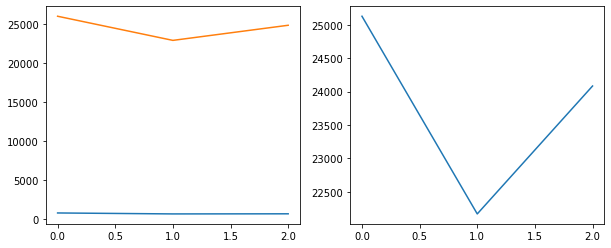

In [226]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(C[:,:])
plt.subplot(122)
plt.plot(C[:,1]-C[:,0])

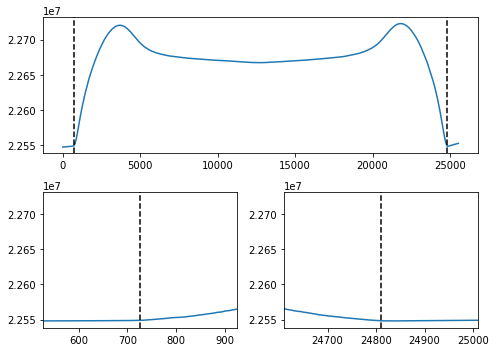

In [229]:
# Here we loop over each profile
i = 2
#C[i,0] = C[i-1, 0]-400
#C[i,1] = C[i-1, 1]+-5240
#C[i,0] = 5790
#C[i,1] += 20
plot_bounds(i, C, 200)

In [231]:
np.save(folder+"Clean/bounds_control.npy", C)


## 2. Leveling the profiles

This is the slowest part, since it involves looking at 3 consecutive profiles, and correcting for height displacements. For *most* of the timelapse, you should aim to have the <span style="color:#FF7F0E">**current**</span> profile between the <span style="color:#1F77B4">**past** </span> and <span style="color:#2CA02C">**future**</span> ones.
While some particular timepoints are off just because of small miscalculations in finding the edges, more prevalent issues may arise when the actual biofilm-lb border goes out of focus in either the in or out of plane direction. This will lead to a few consecutive offsets in the same side of the sample.


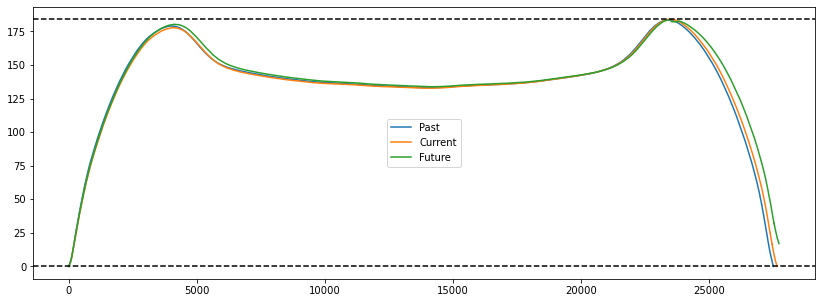

In [217]:
##
i = 87
#offsets[0,1] += 0.5
offsets[i,0] += 0.0
offsets[i,1] += 0.0
offsets[88, 1] += 2
plotrel_profile(i, C, offsets)
#plt.ylim(170, 200)

In [232]:
np.save(folder+"Clean/offsets_control.npy", offsets)
np.save(folder+"Clean/bounds_control.npy", C)


## 3. Displacement alignment

Now we have a set of profile heights that correspond to the same timelapse. Since we work using the center of the colonies, it would be useful to have everything aligned, so we can get the data quickly.

Of course, the size of the first inoculum is much less than the final point. For this, we center everything into a 2D array with ALL the timelapse profiles.

In [219]:
# For timelapses
j = 2                                          # Which of the replicates we'll be working on
offsets = np.load(offnames[j])
C = np.load(Cnames[j]).astype(int)
data = []                                 # We'll do a naive detection of the edges
for i in range(n):
    s = getcleansurf(get_data(files_split[j][i])[0])# Load profiles as a 1-D array
    s_curr = subline(s[C[i,0]:C[i,1]]/1e3, offsets[i,0], offsets[i,1]) # Use edges and offsets to subtract
    data.append(s_curr)

/tmp/ipykernel_3535/1021726904.py:70: RuntimeWarning: divide by zero encountered in true_divide
  f = suma/counts
/tmp/ipykernel_3535/1021726904.py:70: RuntimeWarning: invalid value encountered in true_divide
  f = suma/counts


In [233]:
# For controls
#offsets = np.load(folder+"/Clean/offsets_controls.npy")
#C = np.load(folder+"/Clean/bounds_control.npy").astype(int)
data = []                                 # We'll do a naive detection of the edges
for i in range(n_controls):
    print(i)
    s = getcleansurf(get_data(files_control[i])[0])# Load profiles as a 1-D array
    s_curr = subline(s[C[i,0]:C[i,1]]/1e3, offsets[i,0], offsets[i,1]) # Use edges and offsets to subtract
    data.append(s_curr)

0
1
2


In [234]:
S = np.array([len(x) for x in data])
np.max(S)

25129

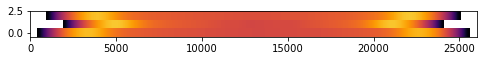

In [235]:
L = 26000
IMG = np.zeros([len(data), L])
IMG[:] = np.nan

start = (L-S)/2
start = start.astype(int)
#shift(31, 37, -20, -50)
#shift(52, 59, -10, -50)
#shift(47, 25)
#shift(80, 70)
#shift(90, 40)
#start[79] += 1000
#start[65] += 2600
#start[66] += 2600

for i in range(len(data)):
    IMG[i, start[i]:len(data[i])+start[i]] = data[i]
plt.figure(figsize=(8,8))
plt.imshow(IMG, aspect=500, clim=(0, 200), origin="lower", cmap="inferno", interpolation="none")

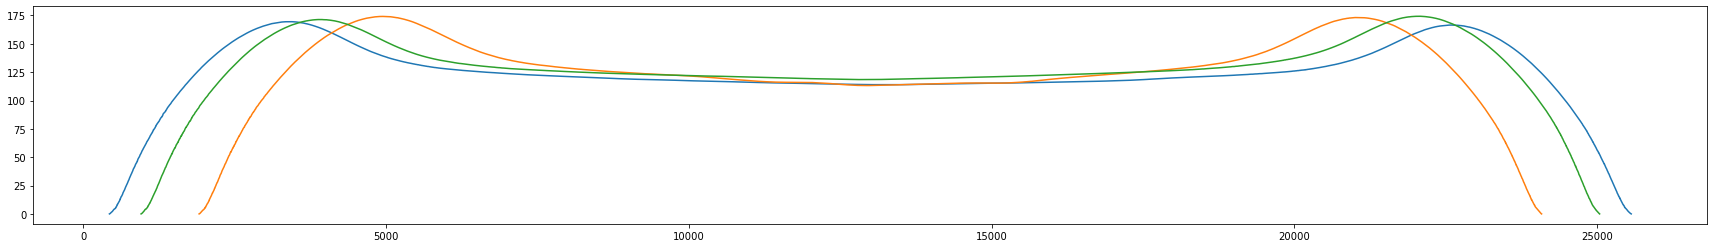

In [236]:
k = 0
k_sp = 3
plt.figure(figsize=(30, 4))
plt.plot(np.transpose(IMG[k:k+k_sp,:]));

In [237]:
np.save(folder+"Clean/bounds_control.npy", C)
np.save(folder+"Clean/offsets_control.npy", offsets)
np.save(folder+"Clean/profiles_control.npy", IMG)
np.save(folder+"Clean/displacement_control.npy", start)

## 4. Save everything into a .csv

Now we have all the required building blocks for our .csv, for each of [A, B, C, control]:
1. Profiles
2. Boundaries
3. Offset
4. Displacement

Now we load everything into a simple panda dataframe, and export it as .csv!

In [238]:
import pandas as pd
df = pd.DataFrame({'file':[], 'replicate':[], 'time':[], 'border_l':[], 'border_r':[], 'offset_l':[], 'offset_r':[], 'displacement':[]})

replicate = ["A", "B", "C"]
times = np.load(folder+"Clean/times.npy")
# Loop over ABC
for j in range(3):
    offsets = np.load(offnames[j])
    C = np.load(Cnames[j])
    displ = np.load(dnames[j])
    t = times[:,j]
    repl = np.repeat(replicate[j], len(t))
    fnames = [name[len(folder)+4:] for name in files_split[j]]
    b_l, b_r = C[:,0], C[:,1]
    o_l, o_r = offsets[:,0], offsets[:,1]
    tf = pd.DataFrame({'file':fnames, 'replicate':repl, 'time':t, 'border_l':b_l, 'border_r':b_r, 'offset_l':o_l, 'offset_r':o_r, 'displacement':displ})
    df = df.append(tf)
offsets = np.load(folder+"Clean/offsets_control.npy")
C = np.load(folder+"Clean/bounds_control.npy")
displ = np.load(folder+"Clean/displacement_control.npy")
t = np.load(folder+"Clean/times_control.npy")
repl = ["D", "E", "F"]
fnames = [name[len(folder)+4:] for name in files_control]
b_l, b_r = C[:,0], C[:,1]
o_l, o_r = offsets[:,0], offsets[:,1]
tf = pd.DataFrame({'file':fnames, 'replicate':repl, 'time':t, 'border_l':b_l, 'border_r':b_r, 'offset_l':o_l, 'offset_r':o_r, 'displacement':displ})
df = df.append(tf)
df.to_csv(folder+"Clean/cleaning.csv", index=False) 


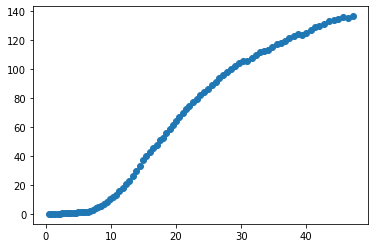

In [222]:
plt.scatter(times_tl[:,1], np.nanmean(IMG[:, 10000:20000], axis=1))

In [97]:
df

,file,replicate,time,border_l,border_r,offset_l,offest_r,displacement
0,mixstrain_001.datx,A,1.044444,4151.0,21253.0,0.0,0.0,11449.0
1,mixstrain_004.datx,A,1.367778,3925.0,20945.0,0.0,0.0,11490.0
2,mixstrain_007.datx,A,1.692222,3617.0,20654.0,0.0,0.0,11481.0
3,mixstrain_010.datx,A,2.016667,3603.0,20685.0,0.0,0.0,11459.0
4,mixstrain_013.datx,A,2.341111,3578.0,20726.0,0.0,0.0,11426.0
...,...,...,...,...,...,...,...,...
91,mixstrain_276.datx,C,47.753333,2608.0,38986.0,0.0,0.0,811.0
92,mixstrain_279.datx,C,48.454444,2511.0,39027.0,0.0,0.0,742.0
0,mixstrain_D.datx,C,48.696111,786.0,37574.0,0.0,0.0,606.0
1,mixstrain_E.datx,C,48.850556,695.0,35307.0,0.0,0.0,1694.0


In [105]:
s1 = np.load(folder+"Clean/profiles_A.npy")[92,:]
s2 = np.load(folder+"Clean/profiles_B.npy")[92,:]
s3 = np.load(folder+"Clean/profiles_C.npy")[92,:]

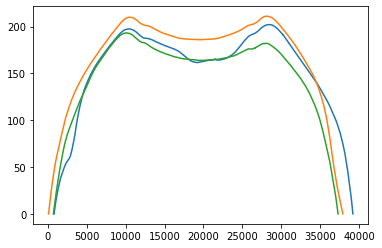

In [108]:
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)

In [102]:
img1.shape

(93, 40000)